In [1]:
import sys
sys.path.append("..")  # Adjusts the path to include the parent directory

from rps_simulation.rps_base import RPS_core  # Importing RPS_core class from rps_base.py
from rps_simulation.rps_multirun import RPS_multirun # Importing RPS_Multirun class, used for main plots

from rps_simulation.learning_curves import exponential_learning, logistic_learning # learonning curves
from rps_simulation.forgetting_curves import exponential_forgetting  # forgetting curves
from rps_simulation.practice_rate import simple_linear_rate  # simple linear rate
from rps_simulation.waiting_times import exponential_waiting_time  # exp waiting time distributi


import numpy as np
import matplotlib.pyplot as plt

# Colour codes for concave and sigmoid curves:
concave_colour = '#466be8'
sigmoid_colour = '#f77150'

plot_dpi = 300 #dpi at which plots will be saved


np.random.seed(10) #setting seed for reproducible results 


# 1. RPS_core Class:

This class generates one instance of the RPS Model. The waiting time distributions, skill update function derived from the learning curve, forgetting rates and practice_rate equation have to be provided and can all be changed. For the plot below, we use an exponential learning curve (with rate $\alpha = 0.2$), exponential forgetting (with rate $\beta = 0.2$) and a simple linear practice rate equation ($\lambda = a + bS$) with $a=0.2, b=5$. The starting skill is $S_0 = 0.1$ and starting practice rate is $\lambda = 0.1$.


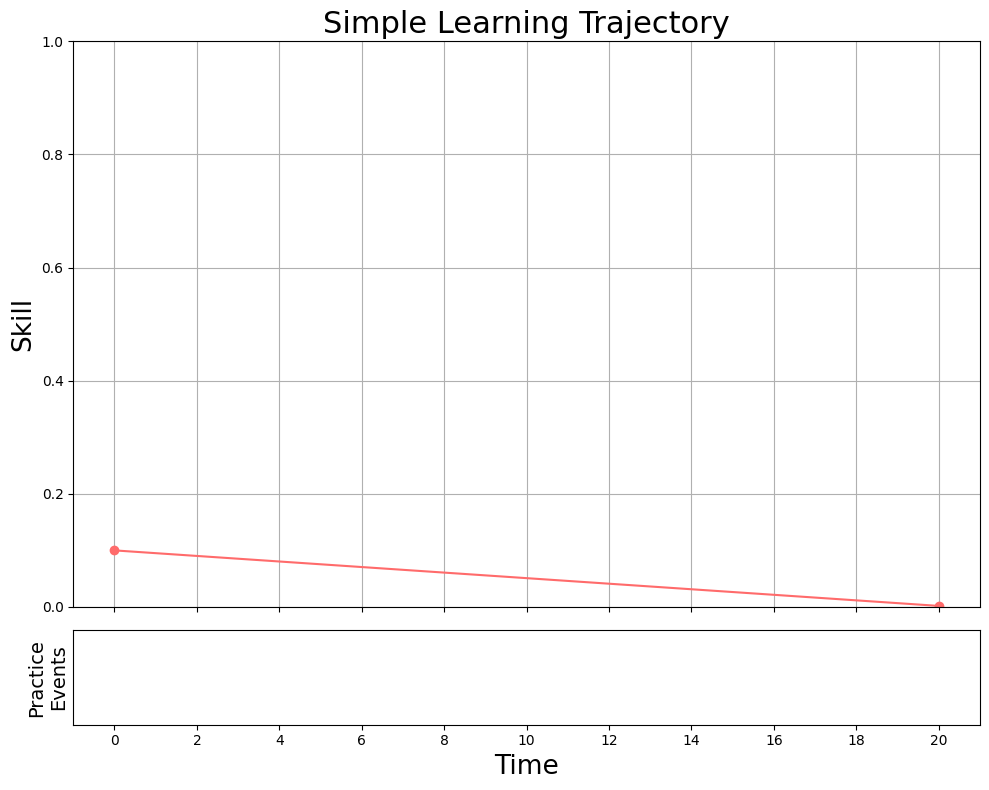

In [12]:

## Defining the learning, forgetting and practice functions:
exp_learning = exponential_learning(alpha=0.2) # alpha is the learning rate
simple_prac_func = simple_linear_rate(a=0.2, b=5) # sample practice function
exp_forgetting = exponential_forgetting(forgetting_rate=0.2) # setting forgetting function to exponential 

# Initializing the RPS_core class:
sample_concave = RPS_core(learning_func = exponential_learning(alpha=0.2),
                    forgetting_func = exponential_forgetting(forgetting_rate=0.2),
                    practice_rate_func = simple_linear_rate(a=0.2, b=5),
                    waiting_time_dist = exponential_waiting_time,
                    initial_skill=0.1, initial_practice_rate=0.1, max_time=20)


# run simulation:
sample_concave.run_simulation()


# simple learning trajectory with markers for practice events:
sample_concave.plot_combined_trajectory(save_location='../plots/sample_simple_traj.jpg', save_dpi=plot_dpi)

# Can also plot smooth trajectory:
# sample_concave.plot_learning_trajectory(least_count=0.25, min_points=5, save_location='../plots/sample_smooth_traj.jpg')

# Can also generate timestamp plots of when practice_events occured:
# sample_concave.practice_times_plot()


# Get data form the simulation run and collect it in a dictionary
# sample_data = sample_concave.data()


# 2. RPS_multirun Class
## 2.1 Concave Simulation and Plots



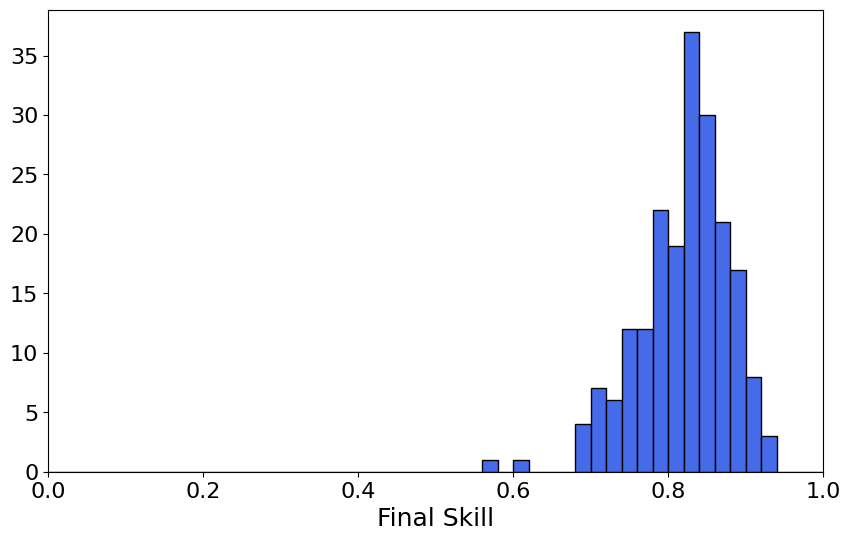

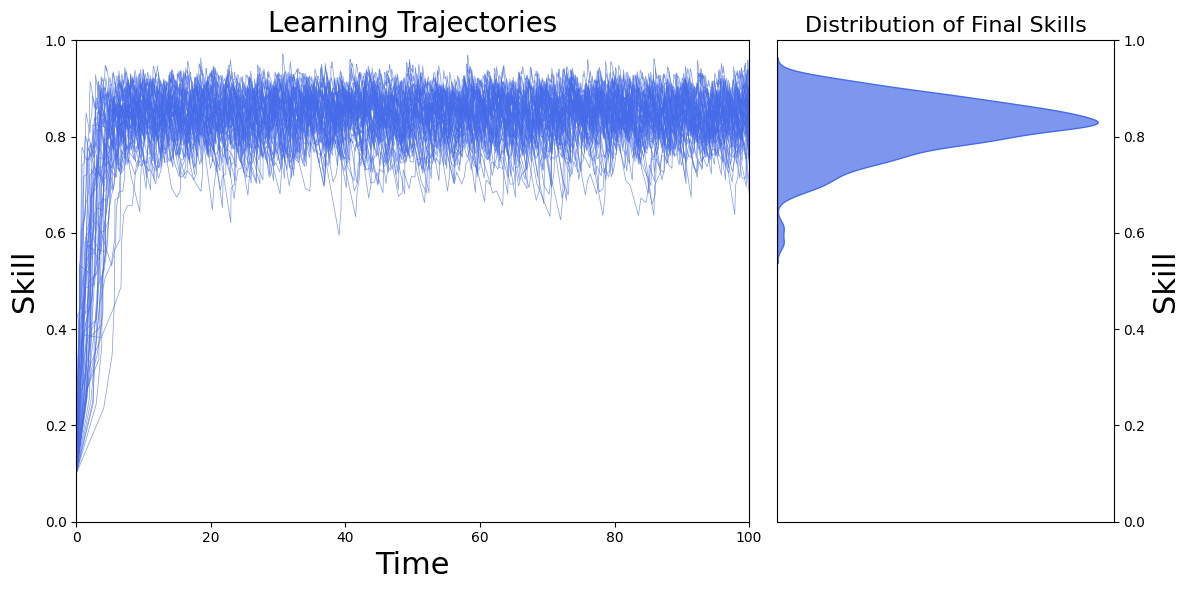

In [3]:
########## Concave Simulation and Plots ##########

# initializing the class
concave_sims = RPS_multirun(learning_func=exp_learning,
                            forgetting_func=exp_forgetting,
                            practice_rate_func=simple_prac_func,
                            waiting_time_dist=exponential_waiting_time,
                            n_sims=200,
                            interpol_dict = {'least_count':1, 'min_points':5})
# running the simulations
concave_sims.run_multiple_sims(interpolate_forgetting = False) # set to False to skip calculating interpolated skills 
                                  # when not practicing. Computationaly expensive but required if you want smooth plots. 
                              

concave_colour = '#466be8'
# plot final skill histogram:
concave_sims.plot_final_skill_histogram(colour=concave_colour)
 
# combined_plot of learning trajectories + histogram of final skills:
concave_sims.plot_trajectory_and_histogram(colour_lineplots=concave_colour, colour_histogram=concave_colour, 
                                           n_plots=50, bw_adjust=0.7, save_location='../plots/concave_sim_summ.jpg', save_dpi=plot_dpi)




## 2.2 Sigmoid Simulation and Plots

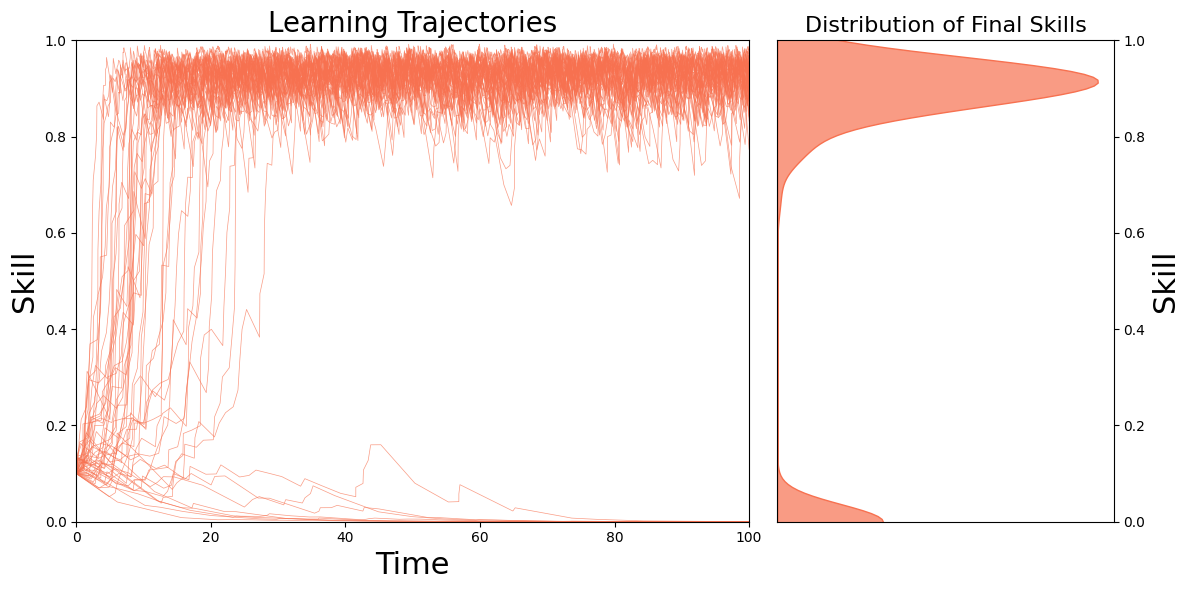

In [4]:
# initializing the class
sigmoid_sims = RPS_multirun(learning_func=logistic_learning(alpha=0.4),
                            forgetting_func=exp_forgetting,
                            practice_rate_func=simple_prac_func,
                            waiting_time_dist=exponential_waiting_time,
                            n_sims=200)

# running the simulations
sigmoid_sims.run_multiple_sims(interpolate_forgetting=False) 

sigmoid_colour = '#f77150'

# combined_plot of learning trajectories + histogram of final skills:
#sigmoid_sims.plot_summary_cogsci(colour_lineplots=sigmoid_colour, colour_histogram=sigmoid_colour, n_plots=50, bw_adjust=0.3, 
sigmoid_sims.plot_trajectory_and_histogram(colour_lineplots=sigmoid_colour, colour_histogram=sigmoid_colour,
                                           n_plots=50, bw_adjust=0.3, save_location='../plots/sigmoid_sim_summ.jpg', save_dpi=plot_dpi)



# 3. Effect of Different Practice Rate Equations:
## 3.1 Simple Linear Practice Rate:
The *simple_linear_rate* practice function used the equation $\lambda = a + bS$  to calculate the practice rate. Thus the higher the current skill, the higher the pratice rate (motivation) of a learner. This is not very realistic since because practice rate may also depend on whether the learner is improving or getting worse. Think of a highly motivated learner of chess who improve their skill (ELO rating) rapidly in the beginning. As learning reaches a plateau they may be less motivated than before, although they now have higher skill. Such scenarios can be captured by modifying the practice rate equation. 

## 3.2 Linear Practice Rate plus Change:
The practice rate function *linear_rate_plus_change* uses the equation (Default $a=0.2, b=5, c=1$):
$$\lambda = a  + bS + c(S - S_{prev})$$

The third term $c(S-S_{prev})$ adds the (weighted) difference of skill after previous practice-event ($S_{prev}$)  from the skill just after the current practice-event ($S$). If the current skill is higher, the learner is improving and it has a motivating effect and increases practice rate. If the current skill is lower than before, this has a demotivating effect and decreases the practice rate.

## 3.3 General Linear Practice Rate:
Both the cases above are special cases of the current practice rate $\lambda$ being a linear sum of skill history. Let the vector $\mathbf{S} = (S_0, S_1, \dots , S_n)$ be the vector (python list) of skills measured at each practice-event. Here $S_0$ is the initial skill, $S_1$ the skill after first practice-event and so on. $S_n$ is the skill after the current practice-event (so there have been $n$ practice events so far). 

The practice rate equation above can be re-written as:
* $\lambda = a + bS_n$ in case **3.1** (simple linear practice rate)
* $\lambda = a + (b+c)S_n + (-c)S_{n-1}$ in case **3.2** (linear practice rate plus change)

Both of these are general cases of general equation:
\begin{equation}
\lambda = w_0 + w_1 \cdot S_n + w_2 \cdot S_{n-1} + \cdots + w_k \cdot S_{n-k+1}
\end{equation}


Here, $\mathbf{w} = (w_0, w_1, \dots, w_k)$ is the vector (python list) of weights. $w_0$ is the constant term (same as $a$ above). $w_1$ is the weight given to the current skill $S_n$, $w_2$ the weight of skill $S_{n-1}$ and so on. The current skill $S_n$ and the previous $k-1$ skills $\{ S_{n-1}, S_{n-2}, \dots ,  S_{n-(k-1)} \}$ are used in the computation of the practice rate. 

**Example:** Suppose you want the current practice rate to only depend on the current skill $S_n$ and previous 2 skills (if they exist) $\{ S_{n-1}, S_{n-2} \}$. Then define $\mathbf{w} = (w_0, w_1, w_2, w_3)$ as the weights matrix. The function *general_linear_practice_rate* returns the practice rate using the general equation. A demonstration is given below:



In [5]:
from rps_simulation.practice_rate import linear_rate_plus_change, general_linear_rate

skill_history = [0.1, 0.2, 0.3, 0.4, 0.5]
weights = [2, 1, 0.5, 0.25]

# practice rate can't go below min_rate=0.01 by Default, since it has to be positive
rate = general_linear_rate(weights, min_rate=0.01).calculate(skill_history)

print('Practice Rate: ' + str(rate))


Practice Rate: 2.775


Now running sumulations the practice rate including change:

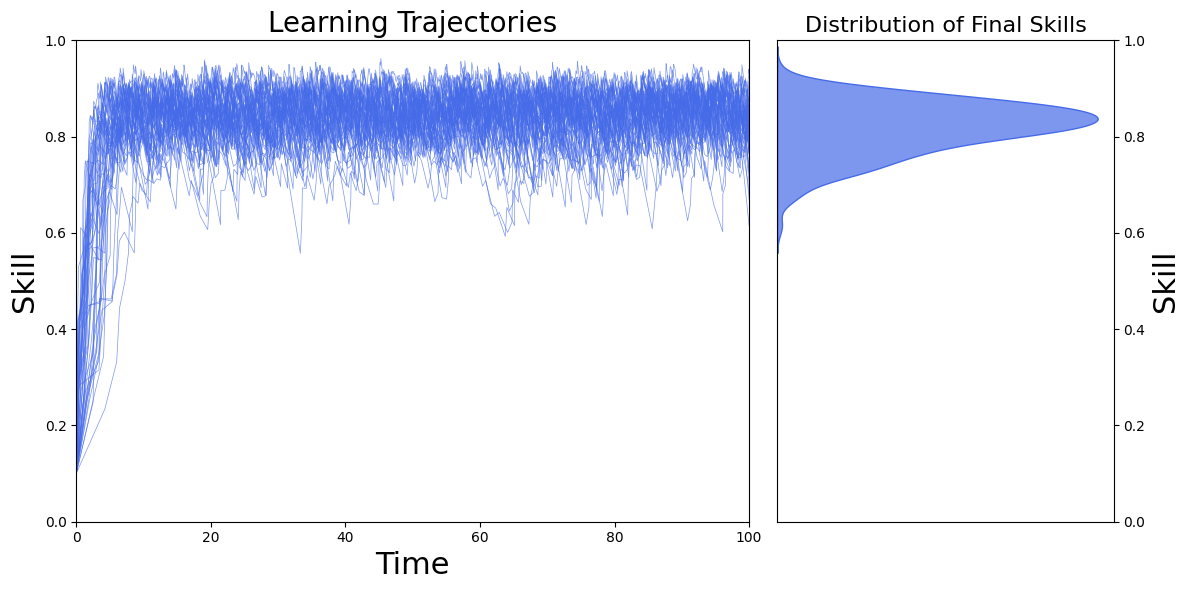

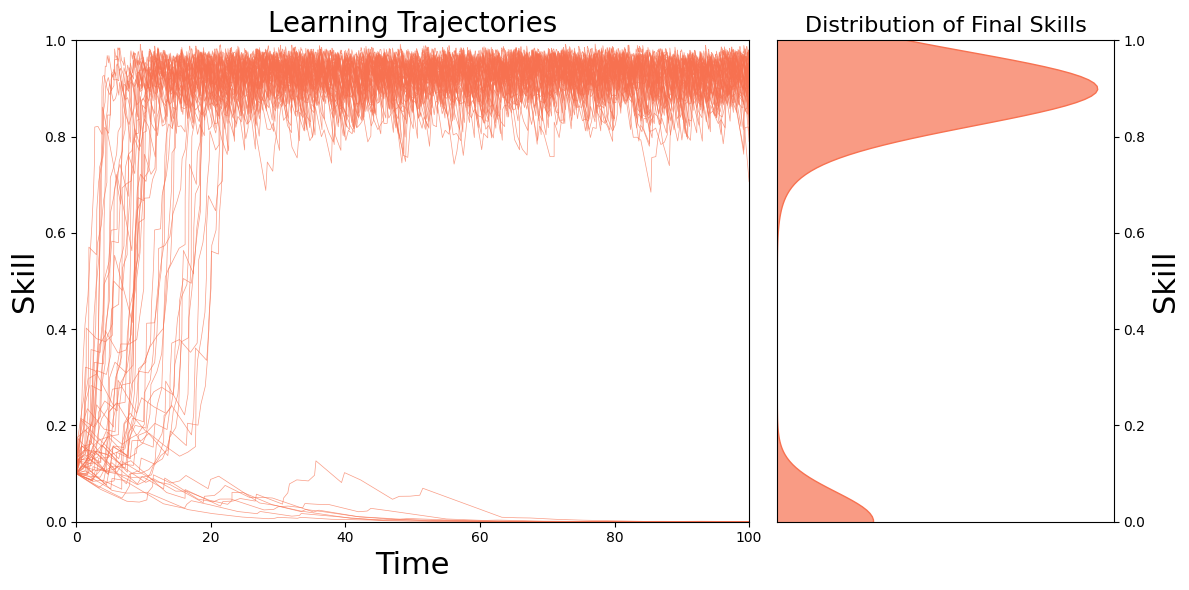

In [6]:
concave_colour = '#466be8'
sigmoid_colour = '#f77150'

######## 3.2 linear_rate_plus_change  ########
prac_rate_with_change = linear_rate_plus_change(a=0.2, b=5, c=2, min_rate=0.01)

# Running sims with linear_rate_plus_change as the practice rate function: 
concave_sims_pr1 = RPS_multirun(learning_func=exponential_learning(alpha=0.2),
                    forgetting_func=exp_forgetting,
                    practice_rate_func=prac_rate_with_change,
                    waiting_time_dist=exponential_waiting_time,
                    n_sims=200)

sigmoid_sims_pr1 = RPS_multirun(learning_func=logistic_learning(alpha=0.4),
                    forgetting_func=exp_forgetting,
                    practice_rate_func=prac_rate_with_change,
                    waiting_time_dist=exponential_waiting_time,
                    n_sims=200)


# running the simulations
concave_sims_pr1.run_multiple_sims(interpolate_forgetting=False) 
sigmoid_sims_pr1.run_multiple_sims(interpolate_forgetting=False) 

# combined_plots:
concave_sims_pr1.plot_trajectory_and_histogram(colour_lineplots=concave_colour, colour_histogram=concave_colour, 
                                               n_plots=50, bw_adjust=1, save_location='../plots/concave_sim_pr1_summary.jpg', save_dpi=plot_dpi)
sigmoid_sims_pr1.plot_trajectory_and_histogram(colour_lineplots=sigmoid_colour, colour_histogram=sigmoid_colour,
                                               n_plots=50, bw_adjust=0.5, save_location='../plots/sigmoid_sim_pr1_summary.jpg', save_dpi=plot_dpi)


# 4. Forgetting Curves
Along with the exponential forgetting function tried earlier: $S(t) = S_0 e^{-\beta t}$, now we now also try the power law forgetting: 
$$S(t) = \frac{S_0}{(1+t)^\beta}$$
We simulate $n=200$ concave and sigmoid learners as the basic RPS model, changing only the forgetting curve to a power law with $\beta=0.4$ as the forgetting rate. 

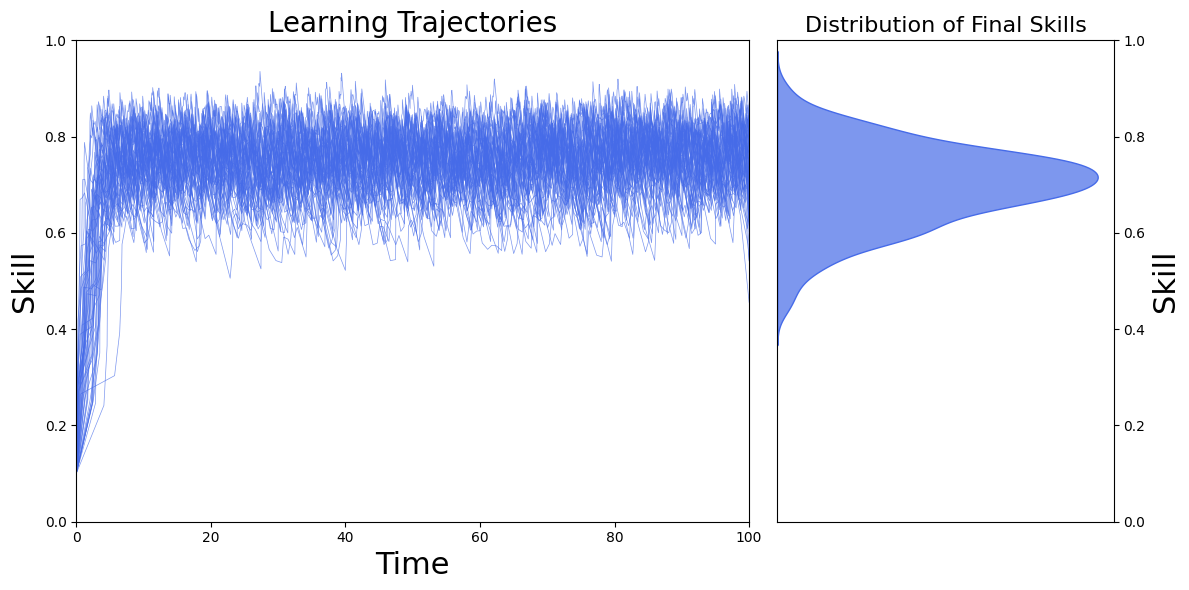

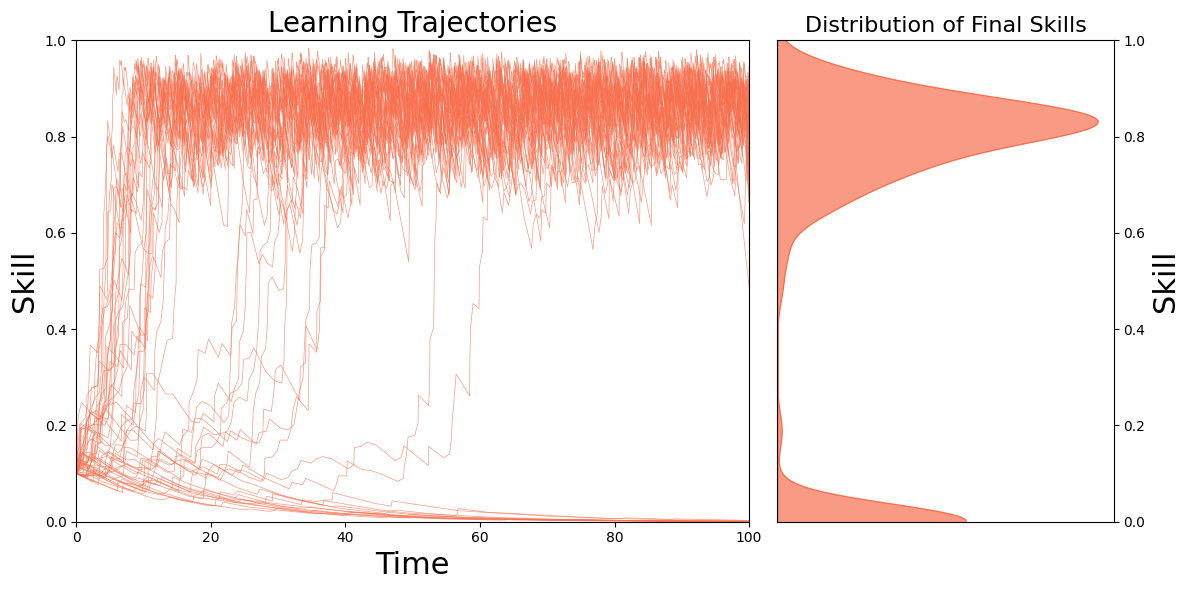

In [7]:
######## Exponential vs. Power Laws of Forgetting  ########
from rps_simulation.forgetting_curves import exponential_forgetting, power_forgetting   # importing forgetting classes

simple_prac_func = simple_linear_rate(a=0.2, b=5) # default a+bS practice rate
exp_forgetting = exponential_forgetting(forgetting_rate=0.2) # exponential forgetting with fixed rate = 0.2
pow_forgetting = power_forgetting(forgetting_rate=0.4) # power forgetting with fixed rate

# Running sims with both pareto forgetting curves for comparison:
concave_sims_fgt_pow = RPS_multirun(waiting_time_dist=exponential_waiting_time,
                                 learning_func=exponential_learning(alpha=0.2),
                                 forgetting_func=pow_forgetting,
                                 practice_rate_func=simple_prac_func,
                                 n_sims=200)

sigmoid_sims_fgt_pow = RPS_multirun(waiting_time_dist=exponential_waiting_time,
                                 learning_func= logistic_learning(alpha=0.4),
                                 forgetting_func=pow_forgetting,
                                 practice_rate_func=simple_prac_func,
                                 n_sims=200)
# running the simulations
concave_sims_fgt_pow.run_multiple_sims(interpolate_forgetting=False) 
sigmoid_sims_fgt_pow.run_multiple_sims(interpolate_forgetting=False) 

# combined_plots:
concave_sims_fgt_pow.plot_trajectory_and_histogram(colour_lineplots=concave_colour, colour_histogram=concave_colour, 
                                                   n_plots=50, bw_adjust=0.9, save_location='../plots/concave_sim_fgt_pow_summary.jpg', save_dpi=plot_dpi)
sigmoid_sims_fgt_pow.plot_trajectory_and_histogram(colour_lineplots=sigmoid_colour, colour_histogram=sigmoid_colour, 
                                                   n_plots=50, bw_adjust=0.3, save_location='../plots/sigmoid_sim_fgt_pow_summary.jpg', save_dpi=plot_dpi)






# 6. Learning Curves:
## 6.1 Alternative Concave Curves:
Power Learning Curve: 
        $$S(t)  = S_{max} - \frac{(S_{max}-S_0)}{(1+t)^\alpha}$$

Its derivative is:
        $$ \frac{dS}{dt} =  \alpha (S_{max} - S) \left( \frac{S_{max} - S}{S_{max} - S_0} \right)^{1/\alpha} $$


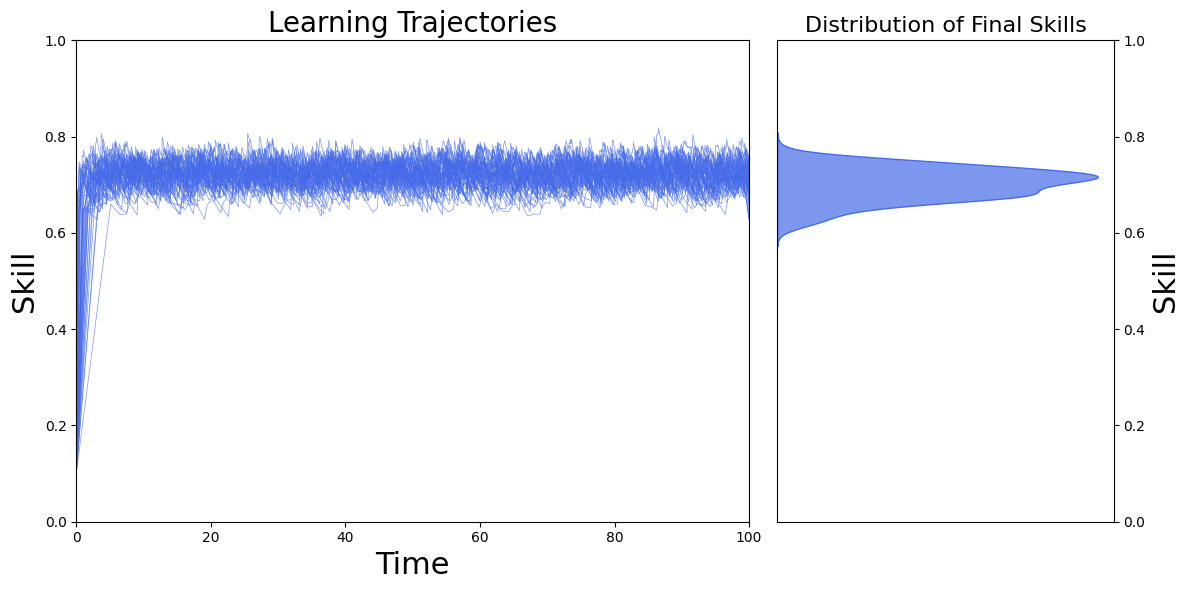

In [8]:
######## Power Concave Curve  ########
from rps_simulation.learning_curves import power_learning

"""
On top of power learning, we also assume power forgetting. These don't change qualitative results
"""

pow_learning = power_learning(alpha=0.6, skill_start=0.1, skill_max=1) # power curves need to specify their starting skill 'skill_start'
simple_prac_func = simple_linear_rate(a=0.2, b=5) # default a+bS practice rate
#exp_forgetting = exponential_forgetting(forgetting_rate=0.2) # exponential forgetting with fixed rate = 0.2
pow_forgetting = power_forgetting(forgetting_rate=0.2) # power forgetting with fixed rate 

# Power Learning  + Power Forgetting:
concave_sims_power = RPS_multirun(learning_func=pow_learning,
                        forgetting_func=pow_forgetting,
                        practice_rate_func=simple_prac_func,
                        waiting_time_dist=exponential_waiting_time,
                        n_sims=200, initial_skill=0.1, initial_practice_rate=1, max_time=100)

# running the simulations
concave_sims_power.run_multiple_sims(interpolate_forgetting=False) 


# combined_plots:
concave_sims_power.plot_trajectory_and_histogram(colour_lineplots=concave_colour, colour_histogram=concave_colour, n_plots=50,
                                        bw_adjust=1, save_location='../plots/powLearn_powFor_summ.jpg', save_dpi=plot_dpi)

#concave_sims_power.plot_summary_cogsci(colour_lineplots=concave_colour, colour_histogram=concave_colour, 
#                                       n_plots=50, bw_adjust=0.7)

## 6.2 Alternate Sigmoid Curves:
compount Exponential Curve (Murre 2014) given by:
$$ S(t) = (1 - e^{-\alpha t})^c  \qquad \qquad \text{...(Learning Curve)} $$

$$ \frac{dS}{dt} = \alpha S^{1 - \frac{1}{c}} (1 - S^{\frac{1}{c}}) \qquad \qquad \text{...(Impact Function)} $$

Richards Curves:
$$ \frac{dS}{dt} = \alpha S(1-S)^{\nu} \qquad \qquad \text{...(Impact Function)} $$


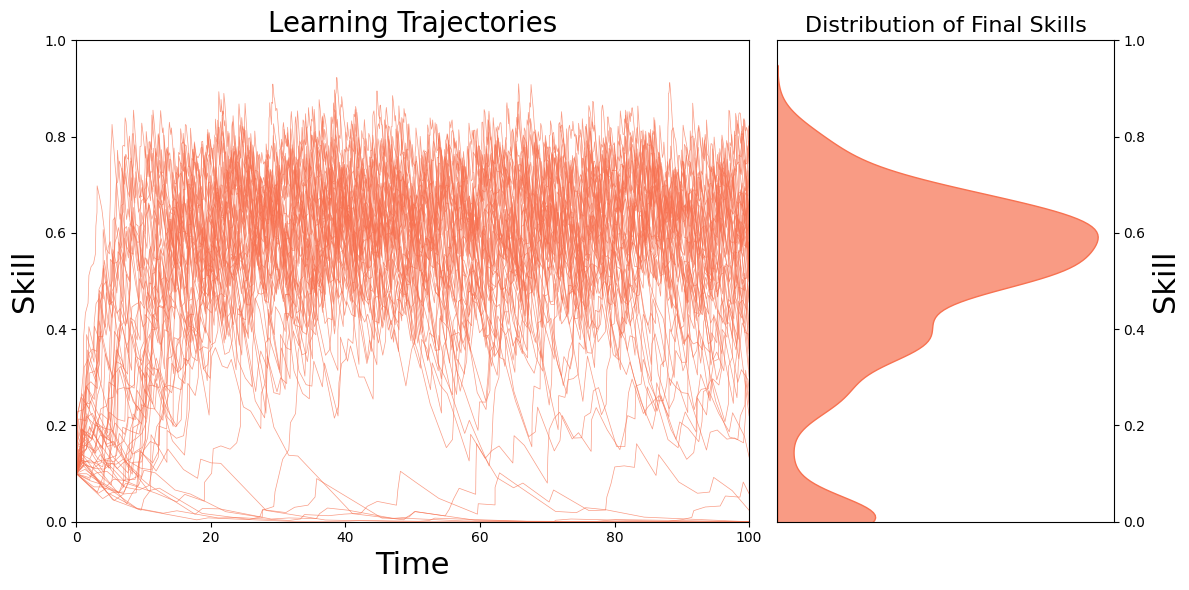

In [9]:
from rps_simulation.learning_curves import compound_exp_learning, richards_learning

"""
On top of the comp. exp, we also assume power forgetting. Again, these don't change qualitative results
"""

comp_exp_learn = compound_exp_learning(alpha=0.8, c=4 , skill_max=1) # power curves need to specify their starting skill 'skill_start'
rich_learn = richards_learning(alpha=0.4, nu=2,skill_max=1) # richards learning

simple_prac_func = simple_linear_rate(a=0.2, b=5) # default a+bS practice rate
pow_forgetting = power_forgetting(forgetting_rate=0.4) # power forgetting with fixed rate 

######## Compount Exponential Curve  ########
sigmoid_sims_comp_exp = RPS_multirun(learning_func=comp_exp_learn,
                        forgetting_func=exponential_forgetting(forgetting_rate=0.4),
                        practice_rate_func=simple_prac_func,
                        waiting_time_dist=exponential_waiting_time,
                        n_sims=200, initial_skill=0.1, initial_practice_rate=1, max_time=100)

# running the simulations
sigmoid_sims_comp_exp.run_multiple_sims(interpolate_forgetting=False) 

# combined_plots:
sigmoid_sims_comp_exp.plot_trajectory_and_histogram(colour_lineplots=sigmoid_colour, colour_histogram=sigmoid_colour,
                                           n_plots=50,bw_adjust=0.6, save_location='../plots/ComExpLearn_powFor_summ.jpg',  save_dpi=plot_dpi)




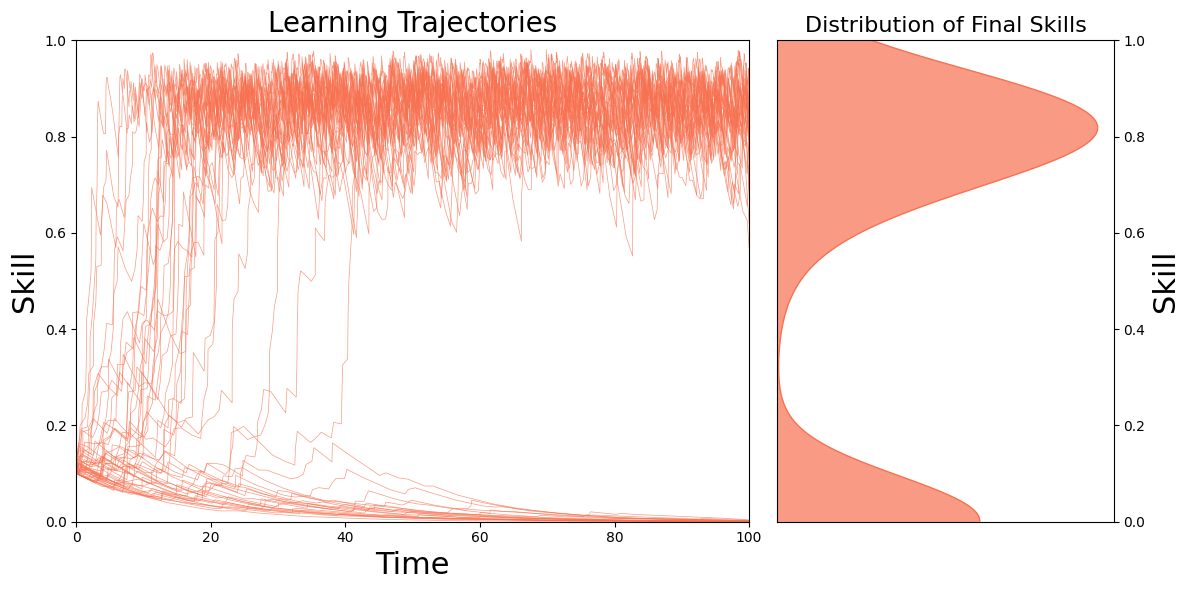

In [10]:
######## Richards Curve  ########
sigmoid_sims_richards = RPS_multirun(learning_func=rich_learn,
                        forgetting_func=pow_forgetting,
                        practice_rate_func=simple_prac_func,
                        waiting_time_dist=exponential_waiting_time,
                        n_sims=200, initial_skill=0.1, initial_practice_rate=1, max_time=100)

# running the simulations
sigmoid_sims_richards.run_multiple_sims() 

# combined_plots:
sigmoid_sims_richards.plot_trajectory_and_histogram(colour_lineplots=sigmoid_colour, colour_histogram=sigmoid_colour,
                                          n_plots=50,bw_adjust=0.7, save_location='../plots/Richards_powFor_summ.jpg', save_dpi=plot_dpi)

# sigmoid_sims_richards.plot_summary_cogsci(colour_lineplots=sigmoid_colour, colour_histogram=sigmoid_colour,
#                                           n_plots=50,bw_adjust=0.7)
